# **VGG-16**

## **VGG-16 Denoising**

In [1]:
# -*- coding: utf-8 -*-

from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, UpSampling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import layers
from google.colab import files


In [2]:
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))
# print(x_train.size)

11501568/11490434 [==============================] - 0s 0us/step


In [3]:
# noise_factor = 0.5
noise_factor = 0.8
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

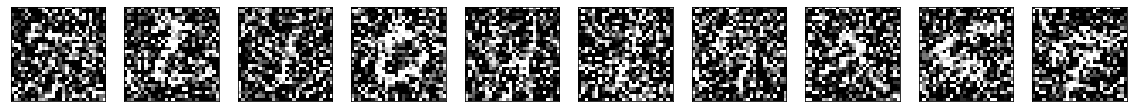

In [4]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [5]:
input_img = Input(shape=(28, 28, 1,)) # N * 28 * 28 * 1

In [6]:
# Encoding: Input 28 * 28 * 1

x = Conv2D(32, (3, 3), padding='same', activation='relu')(input_img) # 28 * 28 * 32
x = Conv2D(64, (3, 3), padding='same', activation='relu')(x) # 28 * 28 * 64 
x = MaxPooling2D((2, 2), padding='same')(x) # 14 * 14 * 64

x = Conv2D(128, (3, 3), padding='same', activation='relu')(x) # 14 * 14 * 128
x = Conv2D(128, (3, 3), padding='same', activation='relu')(x) # 14 * 14 * 128
x = MaxPooling2D((2, 2), padding='same')(x) # 7 * 7 * 128

x = Conv2D(256, (3, 3), padding='same', activation='relu')(x) # 7 * 7 * 256
x = Conv2D(256, (3, 3), padding='same', activation='relu')(x) # 7 * 7 * 256
x = Conv2D(256, (3, 3), padding='same', activation='relu')(x) # 7 * 7 * 256
x = MaxPooling2D((2, 2), padding='same')(x) # 4 * 4 * 256

x = Conv2D(512, (3, 3), padding='same', activation='relu')(x) # 4 * 4 * 512
x = Conv2D(512, (3, 3), padding='same', activation='relu')(x) # 4 * 4 * 512
x = Conv2D(512, (3, 3), padding='same', activation='relu')(x) # 4 * 4 * 512
x = MaxPooling2D((2, 1), padding='same')(x) # 2 * 4 * 512

x = Conv2D(512, (3, 3), padding='same', activation='relu')(x) # 2 * 4 * 512
x = Conv2D(512, (3, 3), padding='same', activation='relu')(x) # 2 * 4 * 512
x = Conv2D(512, (3, 3), padding='same', activation='relu')(x) # 2 * 4 * 512
encoded = MaxPooling2D((2, 1), padding='same')(x) # 1 * 4 * 512

print(encoded.shape)


(None, 1, 4, 512)


In [7]:
# Decoding: Input 1 * 4 * 512

x = Conv2D(512, (3, 3), padding='same', activation='relu')(x) 
x = Conv2D(512, (3, 3), padding='same', activation='relu')(x) 
x = Conv2D(512, (3, 3), padding='same', activation='relu')(x) 
x = UpSampling2D((2, 2))(x) 

x = Conv2D(512, (3, 3), padding='same', activation='relu')(x)
x = Conv2D(512, (3, 3), padding='same', activation='relu')(x)
x = Conv2D(512, (3, 3), padding='same', activation='relu')(x) 
x = UpSampling2D((2, 2))(x)

x = Conv2D(256, (3, 3), padding='same', activation='relu')(x) 
x = Conv2D(256, (3, 3), padding='same', activation='relu')(x) 
x = Conv2D(256, (3, 3), padding='same', activation='relu')(x) 
x = UpSampling2D((2, 2))(x) 

x = Conv2D(128, (3, 3), padding='same', activation='relu')(x) 
x = Conv2D(128, (3, 3), padding='same', activation='relu')(x) 
x = UpSampling2D((2, 2))(x) 

x = Conv2D(64, (3, 3), padding='same', activation='relu')(input_img)
x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)  
x = UpSampling2D((1, 1))(x) # 28 * 28 * 32
decoded = Conv2D(1, (3, 3), padding='same', activation='sigmoid')(x) # 28 * 28 * 1

print(decoded.shape)

(None, 28, 28, 1)


In [8]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [9]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

autoencoder.save('autoencoder.h5')

Epoch 1/100
469/469 [==============================] - 18s 6ms/step - loss: 0.7018 - val_loss: 0.6928
Epoch 2/100
469/469 [==============================] - 3s 6ms/step - loss: 0.6832 - val_loss: 0.6730
Epoch 3/100
469/469 [==============================] - 3s 6ms/step - loss: 0.6604 - val_loss: 0.6466
Epoch 4/100
469/469 [==============================] - 3s 6ms/step - loss: 0.6275 - val_loss: 0.6073
Epoch 5/100
469/469 [==============================] - 3s 6ms/step - loss: 0.5822 - val_loss: 0.5599
Epoch 6/100
469/469 [==============================] - 3s 6ms/step - loss: 0.5378 - val_loss: 0.5234
Epoch 7/100
469/469 [==============================] - 3s 6ms/step - loss: 0.5095 - val_loss: 0.5042
Epoch 8/100
469/469 [==============================] - 3s 6ms/step - loss: 0.4944 - val_loss: 0.4926
Epoch 9/100
469/469 [==============================] - 3s 6ms/step - loss: 0.4836 - val_loss: 0.4826
Epoch 10/100
469/469 [==============================] - 3s 6ms/step - loss: 0.4738 - val_l

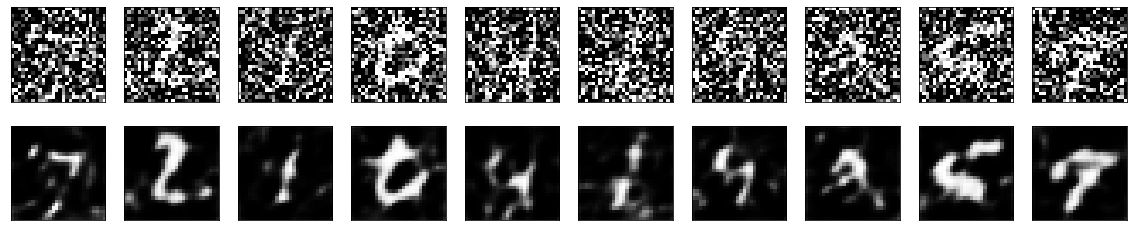

<Figure size 432x288 with 0 Axes>

In [11]:
autoencoder = load_model('autoencoder.h5')

decoded_imgs = autoencoder.predict(x_test_noisy)

n = 10
#n = 1
plt.figure(figsize=(20, 4))
for i in range(n):
    #'''
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    #'''

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()
plt.savefig("sample.png")
# files.download("sample.png")

## **VGG-16 Classification**

In [12]:
from numpy import mean
from numpy import std
from matplotlib import pyplot
from sklearn.model_selection import KFold
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.applications.vgg16 import VGG16


In [13]:
def define_model():
  model = Sequential()

  model.add(Conv2D(32, 3, activation='relu', padding='same', input_shape=(28, 28, 1)))
  model.add(Conv2D(64, 3, activation='relu', padding='same'))
  model.add(MaxPooling2D(2, 2))
  model.add(BatchNormalization())

  model.add(Conv2D(128, 3, activation='relu', padding='same'))
  model.add(Conv2D(128, 3, activation='relu', padding='same'))
  model.add(MaxPooling2D(2, 2))
  model.add(BatchNormalization())

  model.add(Conv2D(256, 3, activation='relu', padding='same'))
  model.add(Conv2D(256, 3, activation='relu', padding='same'))
  model.add(Conv2D(256, 3, activation='relu', padding='same'))
  model.add(MaxPooling2D(2, 2))
  model.add(BatchNormalization())

  model.add(Conv2D(512, 3, activation='relu', padding='same'))
  model.add(Conv2D(512, 3, activation='relu', padding='same'))
  model.add(Conv2D(512, 3, activation='relu', padding='same'))
  model.add(MaxPooling2D(2, 1)) # default stride is 2
  model.add(BatchNormalization())

  model.add(Conv2D(512, 3, activation='relu', padding='same'))
  model.add(Conv2D(512, 3, activation='relu', padding='same'))
  model.add(Conv2D(512, 3, activation='relu', padding='same'))
  model.add(MaxPooling2D(2, 1)) # default stride is 2
  model.add(BatchNormalization())

  model.add(Flatten())
  model.add(Dense(4096, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(4096, activation='relu'))
  model.add(Dropout(0.5))

  model.add(Dense(10, activation='softmax'))

  # compile model
  opt = SGD(lr=0.01, momentum=0.9)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [14]:
 # evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
	scores, histories = list(), list()
	# prepare cross validation
	kfold = KFold(n_folds, shuffle=True, random_state=1)
	# enumerate splits
	for train_ix, test_ix in kfold.split(dataX):
		# define model
		model = define_model()
		# select rows for train and test
		trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
		# fit model
		history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
		# evaluate model
		_, acc = model.evaluate(testX, testY, verbose=0)
		print('> %.3f' % (acc * 100.0))
		# stores scores
		scores.append(acc)
		histories.append(history)
	return scores, histories

In [15]:
# run the test harness for evaluating a model
def run_test_harness():
  # load dataset
  (trainX, trainY), (testX, testY) = mnist.load_data()
	# reshape dataset to have a single channel
  trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
  testX = testX.reshape((testX.shape[0], 28, 28, 1))
	# one hot encode target values
  trainY = to_categorical(trainY)
  testY = to_categorical(testY)
	#return trainX, trainY, testX, testY

  # prepare pixel data
  train_norm = trainX.astype('float32')
  test_norm = testX.astype('float32')
  train_norm = train_norm / 255.0
  test_norm = test_norm / 255.0
  trainX = train_norm
  testX = test_norm

  # define model
  model = define_model()
	# fit model
  model.fit(trainX, trainY, epochs=10, batch_size=32, verbose=0)
	# save model
  model.save('final_model.h5')
  # load model
  model = load_model('final_model.h5')

	# evaluate model on test dataset
  # _, acc = model.evaluate(testX, testY, verbose=0)
  # print('> %.3f' % (acc * 100.0))

	# evaluate model
  scores, histories = evaluate_model(trainX, trainY)


 
# entry point, run the test harness
run_test_harness()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


> 99.208
> 99.233
> 98.800
> 99.333
> 98.850


In [16]:
# make a prediction for a new image.
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model

from google.colab import files
files.upload()

# load and prepare the image
def load_image(filename):
	# load the image
	img = load_img(filename, grayscale=True, target_size=(28, 28))
	# convert to array
	img = img_to_array(img)
	# reshape into a single sample with 1 channel
	img = img.reshape(1, 28, 28, 1)
	# prepare pixel data
	img = img.astype('float32')
	img = img / 255.0
	return img
 
# load an image and predict the class
def run_example():
	# load the image
  img = load_image('sample.png')
 
  # img = load_image('abc.png')

  # load model
  model = load_model('final_model.h5')
  # predict the class
  digit = softmax2label(model.predict(img.reshape(1,28,28,1))[0])
  print("The number on the image is ", digit)

def softmax2label(prediction):
  max_value = 0
  max_index = 0
  for index, value in enumerate(prediction):
    if value>max_value: 
      max_index = index
      max_value = value
  return max_index
 
# entry point, run the example
run_example()

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


The number on the image is  1


# **Alex Net**

## **Alex Net Denoising**

In [17]:
from torchvision.transforms import ToTensor,ToPILImage
import numpy as np
from keras.datasets import mnist
import os
from PIL import Image

In [18]:
# load data
# Why I dont use the whole dataset is because 
# the size of the input of AlexNet is 224 which is very big compared to the imgs from minist dataset and the ram storage of google colab is too small :(
    
#create directory to store mnist dataset
path = './mnist_datasets/'
if not os.path.exists('./mnist_datasets/'):
  os.makedirs(path)
  os.makedirs(os.path.join(path, 'x_train/'))
  os.makedirs(os.path.join(path, 'x_test/'))
  os.makedirs(os.path.join(path, 'x_noisy_train/'))
  os.makedirs(os.path.join(path, 'x_noisy_test/'))  

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train[:10000,:,:]
x_test = x_test[:1000,:,:]
y_train = y_train[:10000]
y_test = y_test[:1000]

In [19]:
# adding noise
noise_factor = 0.8
x_train = x_train/255
x_test = x_test/255
x_noisy_train = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_noisy_test = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 
x_noisy_train = np.clip(x_noisy_train, 0., 1.)
x_noisy_test = np.clip(x_noisy_test, 0., 1.)

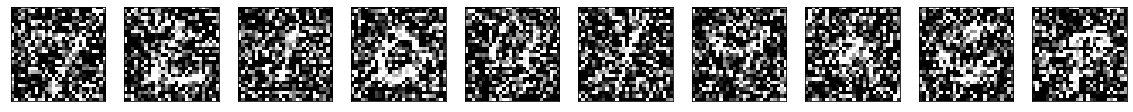

In [20]:
import matplotlib.pyplot as plt
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(x_noisy_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [21]:
# img resize
from keras.preprocessing.image import img_to_array, array_to_img

img_size = 224 #img_size we want to convert to

X_train = np.zeros([len(x_train),img_size,img_size],dtype='float32')
X_test = np.zeros([len(x_test),img_size,img_size],dtype='float32')
X_noisy_train = np.zeros([len(x_train),img_size,img_size],dtype='float32')
X_noisy_test = np.zeros([len(x_test),img_size,img_size],dtype='float32')

for index in range(0, len(x_train)):
  x = np.expand_dims(x_train[index], axis=2)
  x = array_to_img(x)
  img = x.resize((img_size,img_size))
  image_path = "./mnist_datasets/x_train/{}.jpg".format(index+1)
  img.save(image_path)
  img_arr = np.array(img, dtype='float32')
  X_train[index] = img_arr/255

for index in range(0, len(x_test)):
  x = np.expand_dims(x_test[index], axis=2)
  x = array_to_img(x)
  img = x.resize((img_size,img_size))
  image_path = "./mnist_datasets/x_test/{}.jpg".format(index+1)
  img.save(image_path)
  img_arr = np.array(img, dtype='float32')
  X_test[index] = img_arr/255

for index in range(0, len(x_noisy_train)):
  x = np.expand_dims(x_noisy_train[index], axis=2)
  x = array_to_img(x)
  img = x.resize((img_size,img_size))
  image_path = "./mnist_datasets/x_noisy_train/{}.jpg".format(index+1)
  img.save(image_path)
  img_arr = np.array(img, dtype='float32')
  X_noisy_train[index] = img_arr/255

for index in range(0, len(x_noisy_test)):
  x = np.expand_dims(x_noisy_test[index], axis=2)
  x = array_to_img(x)
  img = x.resize((img_size,img_size))
  image_path = "./mnist_datasets/x_noisy_test/{}.jpg".format(index+1)
  img.save(image_path)
  img_arr = np.array(img, dtype='float32')
  X_noisy_test[index] = img_arr/255

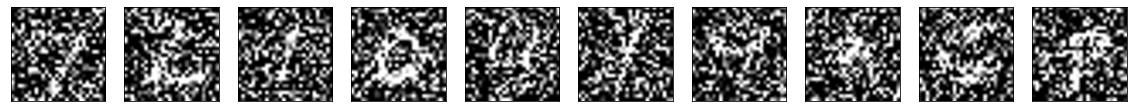

In [22]:
import matplotlib.pyplot as plt
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(X_noisy_test[i].reshape(img_size, img_size))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [23]:
# construct AlexNet based auto encoder
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, Conv2DTranspose, Input, UpSampling2D
import keras
#from keras.layers.normalization import BatchNormalization
from tensorflow.keras.layers import BatchNormalization

input_img = Input(shape=(img_size, img_size, 1))
encoder = Sequential()
#1st Convolutional Layer
encoder.add(Conv2D(filters=96, input_shape=(img_size,img_size,1), kernel_size=(11,11), strides=(4,4), padding='same'))
encoder.add(BatchNormalization())
encoder.add(Activation('relu'))
encoder.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#2nd Convolutional Layer
encoder.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1,1), padding='same'))
encoder.add(BatchNormalization())
encoder.add(Activation('relu'))
encoder.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#3rd Convolutional Layer
encoder.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
encoder.add(BatchNormalization())
encoder.add(Activation('relu')) # 2*2*384

#4rd Convolutional Layer
encoder.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
encoder.add(BatchNormalization())
encoder.add(Activation('relu')) # 2*2*384

#5rd Convolutional Layer
encoder.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
encoder.add(BatchNormalization())
encoder.add(Activation('relu'))
encoder.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

encoded = encoder(input_img)

#encoder.summary()

In [24]:
decoder = encoder

#1rd conv and 1st upsampling
decoder.add(Conv2DTranspose(filters=256, kernel_size=(3,3), strides=(1,1), padding='same')) # 1*1*256
decoder.add(BatchNormalization())
decoder.add(Activation('relu'))
decoder.add(UpSampling2D(size=(2, 2)))  # 2*2*256

#2nd conv
decoder.add(Conv2DTranspose(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
decoder.add(BatchNormalization())
decoder.add(Activation('relu')) # 2*2*384

#3rd conv
decoder.add(Conv2DTranspose(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
decoder.add(BatchNormalization())
decoder.add(Activation('relu')) # 2*2*384

#4th conv and 2nd upsampling
decoder.add(Conv2DTranspose(filters=256, kernel_size=(5, 5), strides=(1,1), padding='same'))
decoder.add(BatchNormalization())
decoder.add(Activation('relu'))
decoder.add(UpSampling2D(size=(2, 2)))  # 4*4*256

#5th conv and 3rd upsampling
decoder.add(Conv2DTranspose(filters=96, input_shape=(img_size,img_size,1), kernel_size=(11,11), strides=(4,4), padding='same'))
decoder.add(BatchNormalization())
decoder.add(Activation('relu'))
decoder.add(UpSampling2D(size=(2, 2))),
decoder.add(Conv2DTranspose(1, (3, 3), padding='same', activation='sigmoid'))

decoded = decoder(input_img)
#decoder.summary()

In [25]:
autoencoder = Model(input_img, decoder(input_img))
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [26]:
if not os.path.exists('/content/autoencoder2.h5'):
  autoencoder.fit(X_noisy_train, X_train,
                  epochs=100,
                  batch_size=128,
                  shuffle=True,
                  validation_data=(X_noisy_test, X_test))

  autoencoder.save('autoencoder2.h5')

Epoch 1/100
79/79 [==============================] - 49s 583ms/step - loss: 0.6447 - val_loss: 0.6644
Epoch 2/100
79/79 [==============================] - 44s 562ms/step - loss: 0.5839 - val_loss: 0.6047
Epoch 3/100
79/79 [==============================] - 44s 563ms/step - loss: 0.5390 - val_loss: 0.5388
Epoch 4/100
79/79 [==============================] - 44s 563ms/step - loss: 0.5034 - val_loss: 0.4835
Epoch 5/100
79/79 [==============================] - 44s 563ms/step - loss: 0.4725 - val_loss: 0.4409
Epoch 6/100
79/79 [==============================] - 44s 562ms/step - loss: 0.4445 - val_loss: 0.4087
Epoch 7/100
79/79 [==============================] - 44s 562ms/step - loss: 0.4190 - val_loss: 0.3796
Epoch 8/100
79/79 [==============================] - 44s 562ms/step - loss: 0.3962 - val_loss: 0.3570
Epoch 9/100
79/79 [==============================] - 44s 562ms/step - loss: 0.3760 - val_loss: 0.3544
Epoch 10/100
79/79 [==============================] - 44s 562ms/step - loss: 0.358

In [27]:
auto_encoder = load_model('autoencoder2.h5')
X_denoising_train = auto_encoder.predict(X_noisy_train)
X_denoising_test = auto_encoder.predict(X_noisy_test)

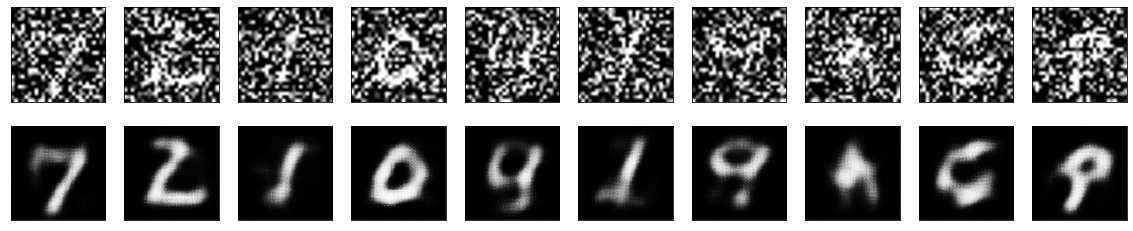

In [28]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_noisy_test[i].reshape(224, 224))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
 
    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(X_denoising_test[i].reshape(224, 224))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## **Alex Net Classification**

In [29]:
# classification
# After we denoising our noisy data sets, we put these decoded img into another alexnet model to do classification.
np.random.seed(1000)

#Instantiation
AlexNet = Sequential()

#1st Convolutional Layer
AlexNet.add(Conv2D(filters=96, input_shape=(img_size,img_size,1), kernel_size=(11,11), strides=(4,4), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#2nd Convolutional Layer
AlexNet.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#3rd Convolutional Layer
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#4th Convolutional Layer
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#5th Convolutional Layer
AlexNet.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#Fully Connected layer
AlexNet.add(Flatten())

# 1st Fully Connected Layer
AlexNet.add(Dense(4096, input_shape=(img_size,img_size,1,)))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
# Add Dropout to prevent overfitting
AlexNet.add(Dropout(0.4))

#2nd Fully Connected Layer
AlexNet.add(Dense(4096))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
#Add Dropout
AlexNet.add(Dropout(0.4))

#3rd Fully Connected Layer
AlexNet.add(Dense(1000))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
#Add Dropout
AlexNet.add(Dropout(0.4))

#Output Layer
AlexNet.add(Dense(10))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('softmax'))

#Model Summary
AlexNet.summary()
AlexNet.compile(loss = keras.losses.categorical_crossentropy, optimizer= 'adam', metrics=['accuracy'])

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_110 (Conv2D)          (None, 56, 56, 96)        11712     
_________________________________________________________________
batch_normalization_40 (Batc (None, 56, 56, 96)        384       
_________________________________________________________________
activation_10 (Activation)   (None, 56, 56, 96)        0         
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 28, 28, 96)        0         
_________________________________________________________________
conv2d_111 (Conv2D)          (None, 28, 28, 256)       614656    
_________________________________________________________________
batch_normalization_41 (Batc (None, 28, 28, 256)       1024      
_________________________________________________________________
activation_11 (Activation)   (None, 28, 28, 256)      

In [30]:
from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

In [31]:
import tensorflow as tf
tf.config.experimental_run_functions_eagerly(True)
AlexNet.fit(X_denoising_train, y_train,
                epochs=50,
                batch_size=128,
                shuffle=True,              
                validation_data=(X_denoising_test, y_test))

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/50
79/79 [==============================] - 9s 116ms/step - loss: 0.8568 - accuracy: 0.7832 - val_loss: 0.8988 - val_accuracy: 0.7260
Epoch 2/50
79/79 [==============================] - 9s 114ms/step - loss: 0.6488 - accuracy: 0.8460 - val_loss: 0.8690 - val_accuracy: 0.7590
Epoch 3/50
79/79 [==============================] - 9s 114ms/step - loss: 0.5864 - accuracy: 0.8584 - val_loss: 0.8217 - val_accuracy: 0.7750
Epoch 4/50
79/79 [==============================] - 9s 115ms/step - loss: 0.5319 - accuracy: 0.8695 - val_loss: 0.6587 - val_accuracy: 0.8170
Epoch 5/50
79/79 [==============================] - 9s 115ms/step - loss: 0.5068 - accuracy: 0.8728 - val_loss: 0.6623 - val_accuracy: 0.8070
Epoch 6/50
79/79 [==============================] - 9s 115ms/step - loss: 0.4457 - accuracy: 0.8905 - val_loss: 0.6212 - val_accuracy: 0.8260
Epoch 7/50
79/79 [==============================] - 9s 115ms/step - loss: 0.4173 - accuracy: 0.8956 - val_loss: 0.6375 - val_accuracy: 0.8160
Epoch 

In [32]:
AlexNet.save('AlexNet.h5')

In [33]:
# only 80%, I think the problem is I only use part of the Mnist dataset instead of the Whole dataset for training to save the runnning time.
classifier = load_model('AlexNet.h5')
scores = classifier.evaluate(X_denoising_test, y_test, verbose=0)
print("Error: %.2f%%" % (100-scores[1]*100))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Error: 16.80%


In [34]:
#convert softmax probability vector into a label
#the input should be 4 dimension, if you want to predict label for an image, you need to reshape it into(1, 224, 224, 1) first
def softmax2label(prediction):
  max_value = 0
  max_index = 0
  for index, value in enumerate(prediction):
    if value>max_value: 
      max_index = index
      max_value = value
  return max_index

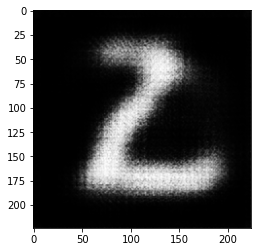

The prediction result is 2






/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


In [35]:
# making prediction
plt.figure(figsize=(20, 4))
plt.imshow(X_denoising_test[1].reshape(224, 224))
plt.show()
#print prediction result
print('The prediction result is {}\n\n\n\n'.format(softmax2label(classifier.predict(X_denoising_test[1].reshape(1,224,224,1))[0])))

# **Res Net-18**

## **Res Net-18 Denoising**

In [36]:
# -*- coding: utf-8 -*-
from keras.datasets import mnist
import numpy as np


(x_train,y_train), (x_test,y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

In [37]:
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

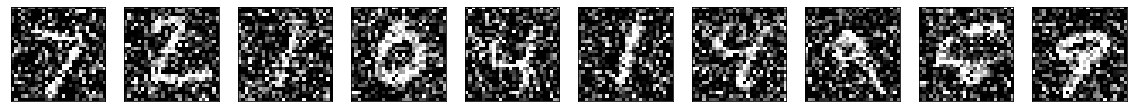

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline

n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [39]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D,AveragePooling2D
from keras.models import Model
#ResNet18 model

#encoding 
input_img = Input(shape=(28, 28, 1,)) # N * 28 * 28 * 1
#conv1
x=Conv2D(64,(7,7),strides=1,padding='same',activation='relu')(input_img) # 28 * 28 * 64
x=MaxPooling2D((2,2),padding='same')(x) # 14 * 14 * 64

#conv2_x
_2x=Conv2D(64,(3,3),padding='same',activation='relu')(x)
_2x=Conv2D(64,(3,3),padding='same',activation='relu')(_2x)
_2x1=_2x-x
_2x=Conv2D(64,(3,3),padding='same',activation='relu')(_2x1)
_2x=Conv2D(64,(3,3),padding='same',activation='relu')(_2x) #14 * 14 * 64
_2x=_2x-_2x1  #14 * 14 * 64
print(_2x.shape)

#conv3_x
_3x=Conv2D(128,(3,3),strides=2,padding='same',activation='relu')(_2x)
_3x=Conv2D(128,(3,3),padding='same',activation='relu')(_3x) # 7 * 7 * 128
_2xr=Conv2D(128,(1,1),strides=2,padding='valid',activation='relu')(_2x)
_3xr=_3x-_2xr
_3x=Conv2D(128,(3,3),padding='same',activation='relu')(_3xr)
_3x=Conv2D(128,(3,3),padding='same',activation='relu')(_3x)# 7 * 7 * 128
_3x=_3x-_3xr
print(_3x.shape)

#conv4_x
_4x=Conv2D(256,(3,3),strides=2,padding='same',activation='relu')(_3x)
_4x=Conv2D(256,(3,3),padding='same',activation='relu')(_4x)#  4 * 4 * 256
_3xr=Conv2D(256,(1,1),strides=2,padding='valid',activation='relu')(_3x)
_4xr=_4x-_3xr
_4x=Conv2D(256,(3,3),padding='same',activation='relu')(_4xr)
_4x=Conv2D(256,(3,3),padding='same',activation='relu')(_4x)
_4x=_4x-_4xr #  4 * 4 * 256
print(_4x.shape)

#conv5_x
_5x=Conv2D(512,(3,3),strides=2,padding='same',activation='relu')(_4x)
_5x=Conv2D(512,(3,3),strides=1,padding='same',activation='relu')(_5x)
_4xr=Conv2D(512,(1,1),strides=2,padding='valid',activation='relu')(_4x)
_5xr=_5x-_4xr # 2 * 2 * 512

_5x=Conv2D(512,(3,3),strides=1,padding='same',activation='relu')(_5xr)
_5x=Conv2D(512,(3,3),strides=1,padding='same',activation='relu')(_5x)
_5x=_5x-_5xr # 2 * 2 * 512
print(_5x.shape)
encoded=AveragePooling2D((2,2),padding='same')(_5x)
print(encoded.shape) #1 * 1 * 512


(None, 14, 14, 64)
(None, 7, 7, 128)
(None, 4, 4, 256)
(None, 2, 2, 512)
(None, 1, 1, 512)


In [40]:
#decoding 1*1*512

#_0y
# _1y=Conv2D(512,(3,3),padding='same',activation='relu')(encoded)
# _1y=Conv2D(512,(3,3),padding='same',activation='relu')(_1y)
# _5xr=Conv2D(512,(1,1),padding='same',activation='relu')(encoded)
# _1yr=_1y-_5xr # 2 * 2 * 512
# _1y=Conv2D(512,(3,3),padding='same',activation='relu')(_1yr)
# _1y=Conv2D(512,(3,3),padding='same',activation='relu')(_1y)
# _1y=_1y-_1yr

#_1y
_1y=UpSampling2D((2,2))(encoded)
_1y=Conv2D(512,(3,3),padding='same',activation='relu')(_1y)
_1y=Conv2D(512,(3,3),padding='same',activation='relu')(_1y)
_5xr=Conv2D(512,(1,1),padding='same',activation='relu')(encoded)
_1yr=_1y-_5xr # 2 * 2 * 512
_1y=Conv2D(512,(3,3),padding='same',activation='relu')(_1yr)
_1y=Conv2D(512,(3,3),padding='same',activation='relu')(_1y)
_1y=_1y-_1yr

_1y=UpSampling2D((2,2))(_1y)
print(_1y.shape)# 4 * 4 * 512
#__2y
_2y=Conv2D(256,(3,3),padding='same',activation='relu')(_1y)
_2y=Conv2D(256,(3,3),padding='same',activation='relu')(_2y)
_1yr=Conv2D(256,(1,1),padding='valid',activation='relu')(_1y)
_2yr=_2y-_1yr # 2 * 2 * 512
_2y=Conv2D(256,(3,3),padding='same',activation='relu')(_2yr)
_2y=Conv2D(256,(3,3),padding='same',activation='relu')(_2y)
_2y=_2y-_2yr#4*4*256
_2y=UpSampling2D((2,2))(_2y)
print(_2y.shape)# 8 * 8 * 256

#_3y
_3y=Conv2D(128,(3,3),padding='same',activation='relu')(_2y)
_3y=Conv2D(128,(3,3),padding='same',activation='relu')(_3y)
_2yr=Conv2D(128,(1,1),padding='valid',activation='relu')(_2y)
_3yr=_3y-_2yr # 2 * 2 * 512
_3y=Conv2D(128,(3,3),padding='same',activation='relu')(_3yr)
_3y=Conv2D(128,(3,3),padding='same',activation='relu')(_3y)
_3y=_3y-_3yr
_3y=UpSampling2D((2,2))(_3y)#16 * 16 * 128
print(_3y.shape)

#_4y
_4y=Conv2D(64,(3,3),padding='same',activation='relu')(_3y)
_4y=Conv2D(64,(3,3),padding='same',activation='relu')(_4y)
_3yr=Conv2D(64,(1,1),padding='valid',activation='relu')(_3y)
_4yr=_4y-_3yr # 2 * 2 * 512
_4y=Conv2D(64,(3,3),padding='same',activation='relu')(_4yr)
_4y=Conv2D(64,(3,3),padding='same',activation='relu')(_4y)
_4y=_4y-_4yr
_4y=UpSampling2D((2,2))(_4y)# 32 * 32 * 64
print(_4y.shape)
#_5y
_5y=Conv2D(64,(1*5),strides=1,padding='valid',activation='relu')(_4y)
print(_5y.shape)
decoded=Conv2D(1,(3*3),padding='same',activation='sigmoid')(_5y)
print(decoded.shape)

(None, 4, 4, 512)
(None, 8, 8, 256)
(None, 16, 16, 128)
(None, 32, 32, 64)
(None, 28, 28, 64)
(None, 28, 28, 1)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/50
469/469 [==============================] - 41s 87ms/step - loss: 0.6226 - val_loss: 0.4711
Epoch 2/50
469/469 [==============================] - 40s 85ms/step - loss: 0.4322 - val_loss: 0.3866
Epoch 3/50
469/469 [==============================] - 40s 85ms/step - loss: 0.3267 - val_loss: 0.2946
Epoch 4/50
469/469 [==============================] - 40s 85ms/step - loss: 0.2858 - val_loss: 0.2798
Epoch 5/50
469/469 [==============================] - 40s 85ms/step - loss: 0.2762 - val_loss: 0.2726
Epoch 6/50
469/469 [==============================] - 40s 85ms/step - loss: 0.2703 - val_loss: 0.2676
Epoch 7/50
469/469 [==============================] - 40s 85ms/step - loss: 0.2660 - val_loss: 0.2636
Epoch 8/50
469/469 [==============================] - 40s 85ms/step - loss: 0.2623 - val_loss: 0.2600
Epoch 9/50
469/469 [==============================] - 40s 86ms/step - loss: 0.2589 - val_loss: 0.2568
Epoch 10/50
469/469 [==============================] - 40s 85ms/step - loss: 0.255

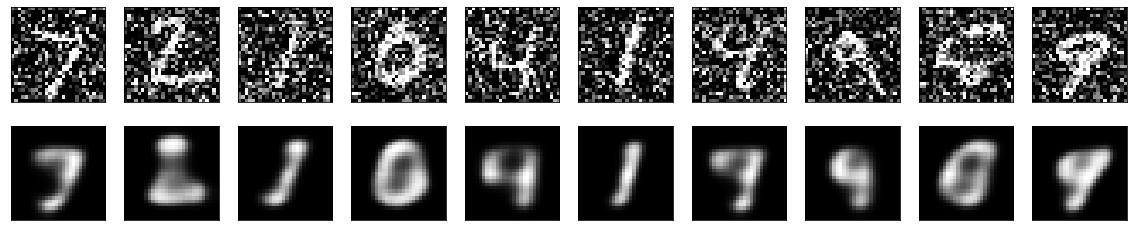

In [41]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.fit(x_train_noisy, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))
decoded_imgs = autoencoder.predict(x_test_noisy)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
 
    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


In [42]:
decoded_train=autoencoder.predict(x_train_noisy)
print(decoded_imgs.shape)
print(decoded_train.shape)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


(10000, 28, 28, 1)
(60000, 28, 28, 1)


## **Res Net-18 Classification**

In [43]:
from keras.utils import np_utils
from keras.layers import Input, Dense, Dropout, Flatten, add
y_test = np_utils.to_categorical(y_test,10)
y_train = np_utils.to_categorical(y_train,10)
print(y_train.shape)

(60000, 10)


In [44]:
#classify
input_img = Input(shape=(28, 28, 1,)) # N * 28 * 28 * 1
#conv1
x=Conv2D(64,(7,7),strides=1,padding='same',activation='relu')(input_img) # 28 * 28 * 64
x=MaxPooling2D((2,2),padding='same')(x) # 14 * 14 * 64

#conv2_x
_2x=Conv2D(64,(3,3),padding='same',activation='relu')(x)
_2x=Conv2D(64,(3,3),padding='same',activation='relu')(_2x)
_2x1=_2x-x
_2x=Conv2D(64,(3,3),padding='same',activation='relu')(_2x1)
_2x=Conv2D(64,(3,3),padding='same',activation='relu')(_2x) #14 * 14 * 64
_2x=_2x-_2x1  #14 * 14 * 64
print(_2x.shape)

#conv3_x
_3x=Conv2D(128,(3,3),strides=2,padding='same',activation='relu')(_2x)
_3x=Conv2D(128,(3,3),padding='same',activation='relu')(_3x) # 7 * 7 * 128
_2xr=Conv2D(128,(1,1),strides=2,padding='valid',activation='relu')(_2x)
_3xr=_3x-_2xr
_3x=Conv2D(128,(3,3),padding='same',activation='relu')(_3xr)
_3x=Conv2D(128,(3,3),padding='same',activation='relu')(_3x)# 7 * 7 * 128
_3x=_3x-_3xr
print(_3x.shape)

#conv4_x
_4x=Conv2D(256,(3,3),strides=2,padding='same',activation='relu')(_3x)
_4x=Conv2D(256,(3,3),padding='same',activation='relu')(_4x)#  4 * 4 * 256
_3xr=Conv2D(256,(1,1),strides=2,padding='valid',activation='relu')(_3x)
_4xr=_4x-_3xr
_4x=Conv2D(256,(3,3),padding='same',activation='relu')(_4xr)
_4x=Conv2D(256,(3,3),padding='same',activation='relu')(_4x)
_4x=_4x-_4xr #  4 * 4 * 256
print(_4x.shape)

x=Flatten()(_4x)
x=Dense(10, activation='softmax')(x)
print(x.shape)

(None, 14, 14, 64)
(None, 7, 7, 128)
(None, 4, 4, 256)
(None, 10)


In [45]:
classification = Model(input_img, x)
classification.compile(optimizer='adadelta', loss='binary_crossentropy',metrics=['accuracy'],)
classification.fit(decoded_train, y_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(decoded_imgs, y_test))
# decoded_imgs = classification.predict(x_test)

Epoch 1/100
  1/469 [..............................] - ETA: 33s - loss: 0.6934 - accuracy: 0.1016

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


469/469 [==============================] - 16s 34ms/step - loss: 0.6823 - accuracy: 0.0933 - val_loss: 0.6681 - val_accuracy: 0.0947
Epoch 2/100
469/469 [==============================] - 16s 34ms/step - loss: 0.6395 - accuracy: 0.1057 - val_loss: 0.5914 - val_accuracy: 0.1164
Epoch 3/100
469/469 [==============================] - 16s 34ms/step - loss: 0.4657 - accuracy: 0.1362 - val_loss: 0.3403 - val_accuracy: 0.1470
Epoch 4/100
469/469 [==============================] - 16s 34ms/step - loss: 0.3308 - accuracy: 0.1811 - val_loss: 0.3275 - val_accuracy: 0.1972
Epoch 5/100
469/469 [==============================] - 16s 34ms/step - loss: 0.3259 - accuracy: 0.2350 - val_loss: 0.3241 - val_accuracy: 0.2818
Epoch 6/100
469/469 [==============================] - 16s 34ms/step - loss: 0.3227 - accuracy: 0.3046 - val_loss: 0.3209 - val_accuracy: 0.3272
Epoch 7/100
469/469 [==============================] - 16s 34ms/step - loss: 0.3196 - accuracy: 0.3393 - val_loss: 0.3179 - val_accuracy: 0.35